In [44]:
#002 What we're going to cover in Milestone Project 2 (NLP for medical abstracts)
#003 SkimLit inputs and outputs
#004 Setting up our notebook for Milestone Project 2 (getting the data)
!nvidia-smi

Wed Mar 20 12:10:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              9W /   80W |    2605MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [45]:
#!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git


In [46]:
#005 Visualising examples from the dataset (becoming one with the data)
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [47]:
import os
filenames = [data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [48]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()
    

In [49]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [50]:
#006 Writing a preprocessing function to structure our data for modelling
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            
            for abstract_line_number , abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)-1
                abstract_samples.append(line_data)
                
        else:
            abstract_lines += line
            
    return abstract_samples
                
        

In [51]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples),len(val_samples),len(test_samples)

CPU times: total: 328 ms
Wall time: 477 ms


(180040, 30212, 30135)

In [52]:
train_samples

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [53]:
#007 Performing visual data analysis on our preprocessed text
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [54]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

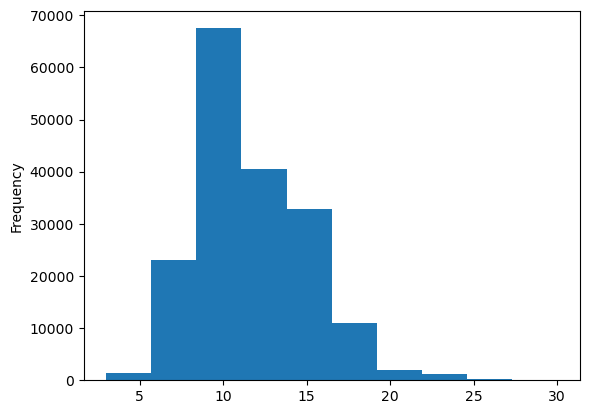

In [55]:
train_df.total_lines.plot.hist()

In [56]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [57]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [58]:
#008 Turning our target labels into numbers (ML models require numbers)
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot

C:\Users\vivek\anaconda3\envs\tensorFlowEnv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [59]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

len(train_labels_encoded)

180040

In [60]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [61]:
#009 Model 0 Creating, fitting and evaluating a baseline model for SkimLit
#Starting a series of modelling experiments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [62]:
model_0.score(X = val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [63]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [64]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [65]:
#010 Preparing our data for deep sequence models
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

#How long each sentence is on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

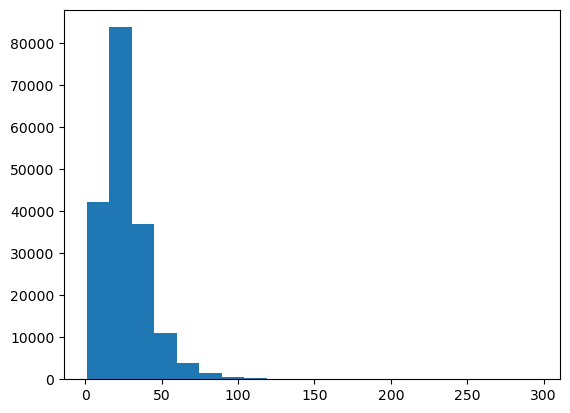

In [66]:
#Distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [67]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [68]:
#011 Creating a text vectoriser to map our tokens (text) to numbers
max_tokens = 68000
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_seq_len)
text_vectorizer.adapt(train_sentences)

In [69]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the average age was @ years and most were male ( @/@ , @ % ) and white ( @/@ , @ % ) .

Length of text: 25

Vectorized text: [[   2  405  103   10   64    3  215    9  564    3 1115    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [70]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [71]:
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [72]:
#012 Creating a custom token embedding layer with TensorFlow
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero=True,
                               name= "token_embedding")

In [73]:
embedded_sentence=token_embed(text_vectorizer([target_sentence]))
embedded_sentence

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.02284544, -0.00606073,  0.03727405, ...,  0.03923101,
          0.02990457,  0.03815868],
        [ 0.01182193,  0.04775507,  0.00064077, ...,  0.00072734,
         -0.03559057, -0.03264104],
        [-0.03359872, -0.03989742, -0.00807871, ...,  0.03282547,
          0.02156555, -0.04890881],
        ...,
        [-0.02745329,  0.03353072,  0.02036579, ...,  0.03064563,
          0.04382603, -0.02422937],
        [-0.02745329,  0.03353072,  0.02036579, ...,  0.03064563,
          0.04382603, -0.02422937],
        [-0.02745329,  0.03353072,  0.02036579, ...,  0.03064563,
          0.04382603, -0.02422937]]], dtype=float32)>

In [74]:
#013 Creating fast loading dataset with the TensorFlow tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [75]:
train_labels_one_hot.shape

(180040, 5)

In [76]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [77]:
#014 Model 1 Building, fitting and evaluating a Conv1D with token embeddings
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [78]:
#014 Model 1 Building, fitting and evaluating a Conv1D with token embeddings
inputs = layers.Input(shape = (1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

#categorical_crossentropy =  when one hot encoded else sparsecategoricalcrossentropy when integers

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [79]:

history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9097 - accuracy: 0.6421 - val_loss: 0.6862 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6585 - accuracy: 0.7562 - val_loss: 0.6322 - val_accuracy: 0.7729
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6186 - accuracy: 0.7749 - val_loss: 0.5961 - val_accuracy: 0.7852


In [80]:
#Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.5974 - accuracy: 0.7857


[0.5974007248878479, 0.7857474088668823]

In [81]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.0017742e-01, 2.2246841e-01, 7.8079320e-02, 2.6461491e-01,
         3.4660015e-02],
        [4.0263668e-01, 3.0869627e-01, 1.2695052e-02, 2.6628518e-01,
         9.6869003e-03],
        [1.5644908e-01, 7.6103741e-03, 1.9391477e-03, 8.3393002e-01,
         7.1334704e-05],
        ...,
        [4.9571640e-06, 1.0648256e-03, 7.8447879e-04, 2.5808486e-06,
         9.9814320e-01],
        [5.6427810e-02, 4.8175937e-01, 8.5053056e-02, 8.1888668e-02,
         2.9487100e-01],
        [1.9794959e-01, 6.6222537e-01, 5.2566975e-02, 4.5506451e-02,
         4.1751582e-02]], dtype=float32),
 (30212, 5))

In [82]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [83]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.57473851449755,
 'precision': 0.7821180310802736,
 'recall': 0.7857473851449756,
 'f1': 0.7828842453348397}

In [84]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [85]:
#015 Preparing a pretrained embedding layer from TensorFlow Hub for Model 2
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        #C:\Users\vivek\AppData\Local\Temp\tfhub_modules\744ecc8f0e54abfc94870bb7a86ec2c67e8724da
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [86]:
random_train_sentence = random.choice(train_sentences)
with tf.device('/CPU:0'):
    print(f"Random sentence:\n {random_train_sentence}")
    use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
    print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
    print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 between april @ and february @ , @ patients undergoing radiotherapy for prostate cancer were enrolled to receive either placebo or famotidine .
Sentence after embedding:
[[-0.06975283  0.03297024 -0.05426717 -0.03673415 -0.02177807 -0.05170482
  -0.05229049 -0.05113872 -0.02786797 -0.06526966  0.08200877 -0.08018942
   0.02762476 -0.04111555  0.04931935  0.02941422 -0.08234589 -0.04710849
   0.02834892 -0.01881655  0.08058234  0.02092949  0.03154998  0.01934956
   0.02723479  0.02019808 -0.05251407 -0.00188137  0.04320213  0.07525147
  -0.01721473  0.0823499   0.04858397 -0.06832188 -0.07987413 -0.02133896
  -0.06021655 -0.06461462 -0.0587427  -0.0789566  -0.00539208  0.02175332
   0.03732007  0.00770326  0.03645644  0.07670718  0.00213287  0.01049349
   0.01944349  0.02087012 -0.04123017 -0.05204813 -0.01859243 -0.02310412
   0.05878683  0.005733   -0.06941391  0.07056347 -0.05830901  0.01879738
  -0.05406749 -0.01233293  0.01579815  0.03568761  0.06170854  0.0144334

In [87]:
#016 Model 2 Building, fitting and evaluating a Conv1D model with token embeddings
inputs = layers.Input(shape = [],dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,outputs=outputs,name = "model_2_USE_feature_extractor")
model_2.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [88]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:
# with tf.device('/CPU:0'):
with tf.device('/CPU:0'):
    history_model_2=model_2.fit(train_dataset,epochs=3,
                                steps_per_epoch=int(0.1*len(train_dataset)),
                                validation_data=valid_dataset,
                                validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 0.9201 - accuracy: 0.6481 - val_loss: 0.7962 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7680 - accuracy: 0.7023 - val_loss: 0.7532 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7510 - accuracy: 0.7126 - val_loss: 0.7350 - val_accuracy: 0.7154


In [92]:
# with tf.device('/CPU:0'):
with tf.device('/CPU:0'):
    model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7395 - accuracy: 0.7160


In [93]:
# with tf.device('/CPU:0'):
with tf.device('/CPU:0'):
    model_2_pred_probs=model_2.predict(valid_dataset)
    model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
    model_2_results = calculate_results(y_true=val_labels_encoded,y_pred=model_2_preds)
    model_2_results

945/945 [==============================] - 11s 11ms/step


In [94]:
model_2_results

{'accuracy': 71.59737852508937,
 'precision': 0.7163245813196902,
 'recall': 0.7159737852508937,
 'f1': 0.7129949894533723}

In [95]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [96]:
#017 Creating a character-level tokeniser with TensorFlow's TextVectorization layer
def split_chars(text):
    return " ".join(list(text))

split_chars(random_train_sentence)

'b e t w e e n   a p r i l   @   a n d   f e b r u a r y   @   ,   @   p a t i e n t s   u n d e r g o i n g   r a d i o t h e r a p y   f o r   p r o s t a t e   c a n c e r   w e r e   e n r o l l e d   t o   r e c e i v e   e i t h e r   p l a c e b o   o r   f a m o t i d i n e   .'

In [97]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[:5])

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .', 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .', 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n 

In [98]:
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

In [99]:
chars_lens

[281,
 137,
 111,
 65,
 209,
 147,
 161,
 164,
 180,
 51,
 188,
 248,
 79,
 167,
 175,
 245,
 120,
 140,
 163,
 186,
 162,
 191,
 251,
 114,
 70,
 131,
 377,
 93,
 94,
 130,
 125,
 209,
 34,
 90,
 118,
 26,
 124,
 43,
 246,
 285,
 65,
 120,
 131,
 131,
 203,
 245,
 195,
 106,
 110,
 144,
 138,
 87,
 59,
 113,
 102,
 146,
 116,
 108,
 217,
 155,
 107,
 112,
 115,
 59,
 201,
 37,
 204,
 129,
 146,
 154,
 89,
 105,
 90,
 66,
 109,
 65,
 93,
 114,
 103,
 212,
 136,
 86,
 225,
 194,
 89,
 263,
 158,
 407,
 100,
 228,
 193,
 106,
 203,
 134,
 148,
 257,
 268,
 296,
 46,
 90,
 113,
 230,
 262,
 193,
 200,
 37,
 240,
 273,
 98,
 176,
 282,
 101,
 177,
 235,
 337,
 100,
 159,
 222,
 201,
 214,
 79,
 132,
 176,
 133,
 93,
 133,
 122,
 241,
 74,
 96,
 164,
 157,
 61,
 166,
 31,
 94,
 134,
 188,
 63,
 128,
 123,
 81,
 38,
 77,
 68,
 120,
 91,
 109,
 108,
 150,
 108,
 265,
 207,
 140,
 270,
 123,
 63,
 161,
 196,
 86,
 272,
 116,
 218,
 48,
 156,
 64,
 492,
 159,
 169,
 206,
 237,
 111,
 126,
 102,

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

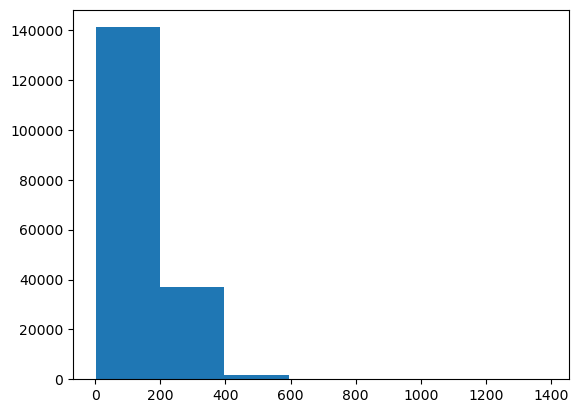

In [100]:
import matplotlib.pyplot as plt
plt.hist(chars_lens,bins=7)

In [101]:
output_seq_char_len = int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [102]:
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [103]:
NUM_CHAR_TOKENS = len(alphabet)+2 #ass 2 for space and OOV ([UNK])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,output_sequence_length=output_seq_char_len,name="char_vectorizer") # set stanadardize = None if you want to leave punctuation in

In [104]:
char_vectorizer.adapt(train_chars)

In [105]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [106]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars:\n {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 c a r e f u l   m o n i t o r i n g   a n d   a p p r o p r i a t e   d o s e   r e d u c t i o n s   o r   i n t e r r u p t i o n s   f o r   a e   m a n a g e m e n t   a r e   r e c o m m e n d e d   d u r i n g   t r e a t m e n t   w i t h   e v e   i n   t h i s   p a t i e n t   p o p u l a t i o n   .

Length of random_train_chars:
 135

Vectorized chars:
 [[11  5  8  2 17 16 12 15  7  6  4  3  7  8  4  6 18  5  6 10  5 14 14  8
   7 14  8  4  5  3  2 10  7  9  2  8  2 10 16 11  3  4  7  6  9  7  8  4
   6  3  2  8  8 16 14  3  4  7  6  9 17  7  8  5  2 15  5  6  5 18  2 15
   2  6  3  5  8  2  8  2 11  7 15 15  2  6 10  2 10 10 16  8  4  6 18  3
   8  2  5  3 15  2  6  3 20  4  3 13  2 21  2  4  6  3 13  4  9 14  5  3
   4  2  6  3 14  7 14 16 12  5  3  4  7  6  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0 

In [107]:
#018 Creating a character-level embedding layer with tf.keras.layers.Embedding
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero=True,
                              name="char_embed")

In [108]:
char_embed(char_vectorizer([random_train_chars]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-0.04708363,  0.01695439,  0.04458586, ..., -0.02082769,
         -0.0011624 ,  0.0122964 ],
        [ 0.0279346 ,  0.01381153,  0.02060399, ..., -0.01334257,
         -0.00161904, -0.03515935],
        [ 0.0153755 ,  0.01400333,  0.00207893, ..., -0.03756376,
          0.04395881,  0.00222192],
        ...,
        [-0.0109712 ,  0.02406137, -0.0137084 , ...,  0.03445753,
         -0.01875897,  0.03319472],
        [-0.0109712 ,  0.02406137, -0.0137084 , ...,  0.03445753,
         -0.01875897,  0.03319472],
        [-0.0109712 ,  0.02406137, -0.0137084 , ...,  0.03445753,
         -0.01875897,  0.03319472]]], dtype=float32)>

In [109]:
char_embed(char_vectorizer([random_train_chars])).shape

TensorShape([1, 290, 25])

In [110]:
#019 Model 3 Building, fitting and evaluating a Conv1D model on character embeddings
inputs = layers.Input(shape=(1,),dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding="same",activation = "relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



In [111]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 

In [112]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [113]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 5ms/step - loss: 1.2755 - accuracy: 0.4913 - val_loss: 1.0460 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 2s 4ms/step - loss: 1.0044 - accuracy: 0.6002 - val_loss: 0.9457 - val_accuracy: 0.6277
Epoch 3/3
562/562 [==============================] - 2s 4ms/step - loss: 0.9237 - accuracy: 0.6388 - val_loss: 0.8657 - val_accuracy: 0.6705


In [114]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [115]:
model_3_results = calculate_results(y_true=val_labels_encoded,y_pred=model_3_preds)
model_3_results

{'accuracy': 66.05653382761817,
 'precision': 0.6531586783664296,
 'recall': 0.6605653382761817,
 'f1': 0.6493164295187899}

In [116]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [117]:
#020 Discussing how we're going to build Model 4 (character + token embeddings)
#021 Model 4 Building a multi-input model (hybrid token + character embeddings)
#Keras Function api can be used to combine multiple layers
token_inputs = layers.Input(shape=[],dtype=tf.string,name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [118]:
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [119]:
#Concatenate token and Char inputs (Hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

In [120]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=output_layer,name = "model_4_token_and_char_embedding")

In [121]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

In [122]:
#022 Model 4 Plotting and visually exploring different data inputs
#Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [123]:
#compile Model
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [124]:
#023 Crafting multi-input fast loading tf.data datasets for Model 4
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#for validation Data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [125]:
train_char_token_dataset,val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [127]:
#024 Model 4 Building, fitting and evaluating a hybrid embedding model
# with tf.device('/CPU:0'):
with tf.device('/CPU:0'):
    history_model_4 = model_4.fit(train_char_token_dataset,
                                  steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                                  epochs = 3,
                                  validation_data=val_char_token_dataset,
                                  validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 53s 90ms/step - loss: 0.9885 - accuracy: 0.6061 - val_loss: 0.7744 - val_accuracy: 0.7031
Epoch 2/3
562/562 [==============================] - 49s 86ms/step - loss: 0.8007 - accuracy: 0.6922 - val_loss: 0.7175 - val_accuracy: 0.7301
Epoch 3/3
562/562 [==============================] - 49s 87ms/step - loss: 0.7735 - accuracy: 0.7048 - val_loss: 0.6928 - val_accuracy: 0.7340


In [129]:
#Wvaluate on Wholde Val dataset
with tf.device('/CPU:0'):
    model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 26s 28ms/step - loss: 0.6953 - accuracy: 0.7345


In [131]:
with tf.device('/CPU:0'):
    model_4_pred_probs = model_4.predict(val_char_token_dataset)
    model_4_preds = tf.argmax(model_4_pred_probs,axis=1)

945/945 [==============================] - 26s 26ms/step


In [132]:
with tf.device('/CPU:0'):
    model_4_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_4_preds)


In [133]:
model_4_results

{'accuracy': 73.4542565867867,
 'precision': 0.7349028864294518,
 'recall': 0.734542565867867,
 'f1': 0.731455806892954}

In [134]:
#025 Model 5 Adding positional embeddings via feature engineering (overview)
#Pretrained token embedding+character Embedding+Positional Embedding
train_df.head()


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [135]:
#026 Encoding the line number feature to used with Model 5
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

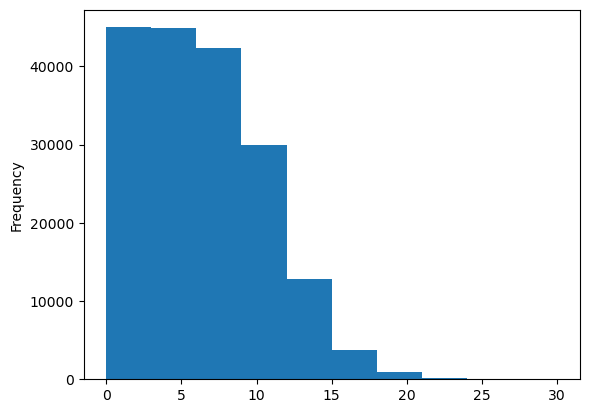

In [136]:
#Cheking the distributuion of line number col
train_df.line_number.plot.hist()

In [137]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [138]:
#027 Encoding the total lines feature to be used with Model 5
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

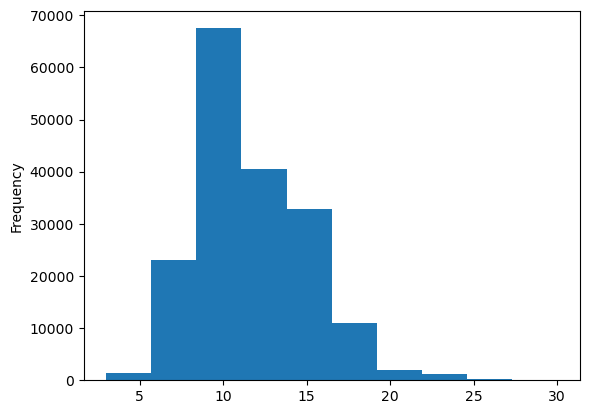

In [139]:
train_df.total_lines.plot.hist()

In [140]:
np.percentile(train_df.total_lines,98)

20.0

In [141]:
train_total_lines_one_hot= tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot= tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot= tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [142]:
#028 Model 5 Building the foundations of a tribrid embedding model
#029 Model 5 Completing the build of a tribrid embedding model for sequences
token_inputs = layers.Input(shape = [],dtype = "string",name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs = token_outputs)

char_inputs = layers.Input(shape = (1,),dtype = "string",name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                           outputs = char_bi_lstm)



line_numbers_inputs=layers.Input(shape = (15,),dtype = tf.float32,name="line_number_input")
x = layers.Dense(32,activation="relu")(line_numbers_inputs)
line_number_model = tf.keras.Model(inputs = line_numbers_inputs,outputs=x )


total_lines_inputs = layers.Input(shape = (20,),dtype = tf.float32,name="total_lines_input")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,outputs=y )



combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])


z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name= "char_token_positional")([line_number_model.output,
                                                                       total_lines_model.output,
                                                                       z])

output_layer = layers.Dense(5,activation="softmax",name="output_layer")(tribrid_embeddings)

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                  total_lines_model.input,
                                  token_model.input,
                                  char_model.input],
                        outputs = output_layer,name="model_5_tribrid_embedding_model")

In [143]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

In [144]:
#030 Visually inspecting the architecture of our tribrid embedding model
#https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])


In [145]:
#031 Creating multi-level data input pipelines for Model 5 with the tf.data API
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset  = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset  = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [146]:
train_char_token_pos_dataset,val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [148]:
#032 Bringing SkimLit to life!!! (fitting and evaluating Model 5)
with tf.device('/CPU:0'):
    history_model_5 = model_5.fit(train_char_token_pos_dataset,
                                  steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                                  epochs = 3,
                                 validation_data=val_char_token_pos_dataset,
                                 validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 51s 88ms/step - loss: 1.1101 - accuracy: 0.7118 - val_loss: 0.9871 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 48s 85ms/step - loss: 0.9667 - accuracy: 0.8174 - val_loss: 0.9494 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 48s 86ms/step - loss: 0.9510 - accuracy: 0.8207 - val_loss: 0.9402 - val_accuracy: 0.8298


In [149]:
with tf.device('/CPU:0'):
    model_5_pred_probs = model_5.predict(val_char_token_pos_dataset,verbose = 1)
    model_5_preds = tf.argmax(model_5_pred_probs,axis=1)

945/945 [==============================] - 25s 24ms/step


In [150]:
with tf.device('/CPU:0'):
    model_5_results = calculate_results(y_true = val_labels_encoded,y_pred=model_5_preds)

In [151]:
model_5_results

{'accuracy': 83.19541903879252,
 'precision': 0.8308962190850673,
 'recall': 0.8319541903879253,
 'f1': 0.8311213798495926}

In [152]:
model_4_results

{'accuracy': 73.4542565867867,
 'precision': 0.7349028864294518,
 'recall': 0.734542565867867,
 'f1': 0.731455806892954}

In [ ]:
#033 Comparing the performance of all of our modelling experiments